In [1]:
import os
import sys

if 'has_changed_dir' not in globals():
    repo_path = os.path.abspath(os.path.join('..'))
    
    if repo_path not in sys.path:
        sys.path.append(repo_path)
    
    os.chdir(repo_path)
    
    globals()['has_changed_dir'] = True

import math
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import TemplateProcessing
from tqdm import tqdm

import neunet
import neunet.nn as nn
from datasets import load_dataset  # type: ignore
from neunet import Tensor
from neunet.optim import Adam


In [2]:
device = "cuda"

In [3]:
# [Model implementation]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.scale = math.sqrt(d_model)
        self.dropout = nn.Dropout(dropout)

        if d_model % n_heads != 0:
            raise ValueError("d_model must be divisible by n_heads")

        self.depth = d_model // n_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.fc = nn.Linear(d_model, d_model)


    def forward(self, q: Tensor, k: Tensor, v: Tensor, mask: Optional[Tensor]=None):
        batch_size = q.shape[0]
        q = self.wq(q).contiguous().reshape(batch_size, -1, self.n_heads, self.depth).transpose(0, 2, 1, 3)
        k = self.wk(k).contiguous().reshape(batch_size, -1, self.n_heads, self.depth).transpose(0, 2, 1, 3)
        v = self.wv(v).contiguous().reshape(batch_size, -1, self.n_heads, self.depth).transpose(0, 2, 1, 3)

        scores = neunet.matmul(q, k.transpose(0, 1, 3, 2)) / self.scale
        if mask is not None:
            mask = mask[:, None, ...]
            scores = neunet.where(mask == 0, -1e9, scores)

        attn = self.dropout(nn.Softmax(axis = -1)(scores))

        x = neunet.matmul(attn, v)
        x = x.contiguous().transpose(0, 2, 1, 3).reshape(batch_size, -1, self.n_heads * self.depth)
        x = self.fc(x)

        return x, attn

In [4]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.fc_1 = nn.Linear(d_model, d_ff)
        self.fc_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

        self.activation = nn.Swish()

    def forward(self, x):
        x = self.fc_1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc_2(x)

        return x


In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.RMSNorm(d_model)
        self.norm2 = nn.RMSNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Masked self-attention (for the target sequence)
        nx1 = self.norm1(x)
        _x, attn = self.self_attn(nx1, nx1, nx1, mask)
        x = x + self.dropout(_x)
        
        # Feed-forward network
        nx2 = self.norm2(x)
        _x = self.ffn(nx2)
        x = x + self.dropout(_x)
        
        return x, attn

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
            https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html
        """
        super(PositionalEncoding, self).__init__()
        pe = neunet.zeros(max_len, d_model, requires_grad=False)
        position = neunet.arange(0, max_len, dtype=neunet.float32)[:, None, ...]
        div_term = neunet.exp(neunet.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = neunet.sin(position * div_term)
        pe[:, 1::2] = neunet.cos(position * div_term)

        self.pe = pe[None, ...]

    def forward(self, x):
        x = x + self.pe[:, :x.shape[1]] # (batch_size, seq_len, d_model)
        return x

In [7]:
class Decoder(nn.Module):
    def __init__(self, tgt_vocab_size, d_model, n_heads, d_ff, n_layers, dropout=0.1, max_len=5000):
        super(Decoder, self).__init__()
        self.token_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.position_embedding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])

        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

        self.scale = math.sqrt(d_model)


    def forward(self, x, mask):
        x = self.token_embedding(x) * self.scale
        x = self.position_embedding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x, attn = layer(x, mask)

        out = self.fc_out(x)
        return out, attn

In [8]:
class GPT(nn.Module):
    def __init__(self, decoder: Decoder, pad_idx) -> None:
        self.decoder = decoder
        self.pad_idx = pad_idx

    def get_pad_mask(self, x):
        #x: (batch_size, seq_len)
        return (x != self.pad_idx).astype(int)[:, np.newaxis, :]

    def get_sub_mask(self, x):
        #x: (batch_size, seq_len)
        seq_len = x.shape[1]
        subsequent_mask = np.triu(np.ones((seq_len, seq_len)), k = 1).astype(int)
        subsequent_mask = np.logical_not(subsequent_mask)
        return subsequent_mask

    def forward(self, x) -> tuple[Tensor, Tensor]:
        # x: (batch_size, target_seq_len)
        # mask: (batch_size, seq_len, seq_len)

        mask = self.get_pad_mask(x) & self.get_sub_mask(x)

        x, mask = neunet.tensor(x, dtype=neunet.int32, device=device), neunet.tensor(mask, dtype=neunet.int32, device=device)
        

        out, attention = self.decoder(x, mask)
        # output: (batch_size, target_seq_len, vocab_size)
        # attn: (batch_size, heads_num, target_seq_len, source_seq_len)
        return out, attention


In [9]:

# [Data preprocessing]

BATCH_SIZE = 4

PAD_TOKEN = '<pad>' # noqa: S105
SOS_TOKEN = '<sos>' # noqa: S105
EOS_TOKEN = '<eos>' # noqa: S105


DATASET_PATH = Path("./datasets/sd-prompts/")
SAVE_PATH = Path("./saved models/gpt/")


if not DATASET_PATH.exists():
    data = load_dataset("Gustavosta/Stable-Diffusion-Prompts", cache_dir="datasets/sd-prompts")

    for split, split_dataset in data.items():

        with Path(f"./datasets/sd-prompts/sd-prompts-{split}.txt").open('w', encoding='utf-8') as f:
            for item in split_dataset:
                f.write(item['Prompt'] + '\n')


FILE_PATHS = [DATASET_PATH / "sd-prompts-train.txt", DATASET_PATH / "sd-prompts-test.txt"]


In [10]:
# [Train and load Tokenizer]

if not (SAVE_PATH / "vocab").exists():
    tokenizer = ByteLevelBPETokenizer()

    tokenizer.train(files=[str(path) for path in FILE_PATHS], vocab_size=15000, min_frequency=1, special_tokens=[
        PAD_TOKEN,
        SOS_TOKEN,
        EOS_TOKEN,
        # UNK_TOKEN
    ])

    (SAVE_PATH / "vocab").mkdir(parents=True)
    tokenizer.save_model(str(SAVE_PATH / "vocab"), "sd-prompts-tokenizer")

tokenizer = ByteLevelBPETokenizer(
    str(SAVE_PATH / "vocab/sd-prompts-tokenizer-vocab.json"),
    str(SAVE_PATH / "vocab/sd-prompts-tokenizer-merges.txt"),
)



PAD_INDEX = tokenizer.token_to_id(PAD_TOKEN)
SOS_INDEX = tokenizer.token_to_id(SOS_TOKEN)
EOS_INDEX = tokenizer.token_to_id(EOS_TOKEN)

In [11]:

class DataPreprocessor():
    def __init__(self, tokenizer: ByteLevelBPETokenizer):
        self.tokenizer = tokenizer

        self.tokenizer._tokenizer.post_processor  = TemplateProcessing( # noqa SLF001
            single=f"{SOS_TOKEN} $A {EOS_TOKEN}",
            special_tokens=[
                (f"{SOS_TOKEN}", tokenizer.token_to_id(f"{SOS_TOKEN}")),
                (f"{EOS_TOKEN}", tokenizer.token_to_id(f"{EOS_TOKEN}")),
            ],
        )

        # self.tokenizer.enable_truncation(max_length=151)
        self.tokenizer.enable_padding(pad_token = PAD_TOKEN)
        
    def tokenize(self, paths: list[str], batch_size: int, lines_limit: Optional[int] = None) -> list[np.ndarray]:
        examples = []

        for src_file in paths:
            print(f"Processing {src_file}")
            path_src_file = Path(src_file)
            lines = path_src_file.read_text(encoding="utf-8").splitlines()

            if lines_limit:
                lines = lines[:lines_limit]

            for i in range(0, len(lines), batch_size):
                examples.append(np.array([x.ids for x in self.tokenizer.encode_batch(lines[i:i+batch_size])]))


        return examples

    def __call__(self, paths: list[str], batch_size: int, lines_limit: Optional[int] = None) -> list[np.ndarray]:
        return self.tokenize(paths, batch_size, lines_limit)

data_post_processor = DataPreprocessor(tokenizer)

train_data = data_post_processor([str(FILE_PATHS[0])], batch_size = BATCH_SIZE, lines_limit=20000)
val_data = data_post_processor([str(FILE_PATHS[1])], batch_size = BATCH_SIZE, lines_limit=2000)

Processing datasets\sd-prompts\sd-prompts-train.txt
Processing datasets\sd-prompts\sd-prompts-test.txt


In [12]:

# [Model intialization]

decoder = Decoder(
    tgt_vocab_size = tokenizer.get_vocab_size(),
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    n_layers = 8,
    dropout = 0.1
)


model = GPT(
    decoder = decoder,
    pad_idx = tokenizer.token_to_id(PAD_TOKEN)
)

model = model.to(device)

optimizer = Adam(model.parameters(), lr=1.5e-4, betas=(0.9, 0.98), eps = 1e-9)

loss_function = nn.CrossEntropyLoss(ignore_index = PAD_INDEX)


In [13]:

# [train, eval, predict methods definition]

def train_step(dataset: list[np.ndarray], epoch: int, epochs: int) -> float:
    total_loss = 0.0
    model.train()

    tqdm_range = tqdm(enumerate(dataset), total = len(dataset))
    for batch_num, batch in tqdm_range:

        output, _ = model.forward(batch[:,:-1])
        
        output = output.reshape(output.shape[0] * output.shape[1], output.shape[2])

        loss = loss_function(output, neunet.tensor(batch[:, 1:].flatten(), device=device, dtype=neunet.int32))
        loss.backward()

        optimizer.step()

        optimizer.zero_grad()
        total_loss += loss.detach().item()


        tqdm_range.set_description(
                f"training | loss: {loss.detach().item():.7f} | perplexity: {np.exp(loss.detach().item()):.7f} | epoch {epoch + 1}/{epochs}" #loss: {loss:.4f}
            )

        if batch_num == (len(dataset) - 1):
            epoch_loss = total_loss / len(dataset)

            tqdm_range.set_description(
                    f"training | avg loss: {epoch_loss:.7f} | avg perplexity: {np.exp(epoch_loss):.7f} | epoch {epoch + 1}/{epochs}"
            )

    return epoch_loss

In [14]:
def eval(dataset: list[np.ndarray]) -> float:
    total_loss = 0.0
    model.eval()

    tqdm_range = tqdm(enumerate(dataset), total = len(dataset))
    for batch_num, batch in tqdm_range:
        
        output, _ = model.forward(batch[:,:-1])
        
        output = output.reshape(output.shape[0] * output.shape[1], output.shape[2])
        
        loss = loss_function(output, neunet.tensor(batch[:, 1:].flatten(), device=device, dtype=neunet.int32))
        total_loss += loss.detach().item()
        
        tqdm_range.set_description(
                f"testing  | loss: {loss.detach().item():.7f} | perplexity: {np.exp(loss.detach().item()):.7f}"
            )

        if batch_num == (len(dataset) - 1):
            epoch_loss = total_loss / len(dataset)

            tqdm_range.set_description(
                    f"testing  | avg loss: {epoch_loss:.7f} | avg perplexity: {np.exp(epoch_loss):.7f}"
            )

    return epoch_loss

In [15]:
def train(train_data: list[np.ndarray], val_data: list[np.ndarray], epochs: int, save_every_epochs: int, save_path: Optional[str] = None, validation_check: bool = False):
    best_val_loss = float('inf')
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):

        train_loss_history.append(train_step(train_data, epoch, epochs))
        val_loss_history.append(eval(val_data))


        if (save_path is not None) and ((epoch + 1) % save_every_epochs == 0):
            if not Path(save_path).exists():
                Path(save_path).mkdir(parents=True, exist_ok=True)
            if validation_check == False:

                neunet.save(model.state_dict(), f"{save_path}/gpt_{epoch + 1}.nt")
            else:
                if val_loss_history[-1] < best_val_loss:
                    best_val_loss = val_loss_history[-1]
                    
                    neunet.save(model.state_dict(), f"{save_path}/gpt_{epoch + 1}.nt")
                else:
                    print('Current validation loss is higher than previous. Not saved.')
                    break
            
    return train_loss_history, val_loss_history

In [16]:
def predict(sentence: str = "", max_length: int = 50, temperature: float = 0.7) -> tuple[str, Tensor]:
    model.eval()

    tokens: list = [SOS_INDEX, *tokenizer.encode(sentence, add_special_tokens=False).ids]
   
    for _ in range(max_length):
        inputs = np.asarray(tokens).reshape(1, -1)

        outputs, attention = model.forward(inputs)

        outputs = outputs[:, -1] / temperature
        outputs = nn.Softmax(axis=-1)(outputs)

        probs = outputs.reshape(-1).detach().cpu().numpy()

        next_token = np.random.choice(len(probs), p=probs)
        
        # next_token = outputs.detach().cpu().numpy().argmax(axis=-1)[:, -1].item() # eq. temperature = 0.0

        tokens.append(next_token)

        if next_token == EOS_INDEX or len(tokens) >= max_length:
            break
    
    # Remove special tokens
    if SOS_INDEX in tokens:
        tokens.remove(SOS_INDEX)
    if EOS_INDEX in tokens:
        tokens.remove(EOS_INDEX)

    decoded_sentence = tokenizer.decode(tokens)

    return decoded_sentence, attention


In [17]:
# [Train the Model]

# model.load_state_dict(neunet.load("./saved models/gpt/gpt_2.nt"))

train_loss_history, val_loss_history = None, None
train_loss_history, val_loss_history = train(train_data, val_data, epochs=30, save_every_epochs=1, save_path = str(SAVE_PATH), validation_check=True)

training | avg loss: 9.2024686 | avg perplexity: 9921.5908248 | epoch 1/30: 100%|██████████| 5000/5000 [12:49<00:00,  6.50it/s]            
testing  | avg loss: 4.6352218 | avg perplexity: 103.0507714: 100%|██████████| 500/500 [00:25<00:00, 19.41it/s]
training | avg loss: 3.7912031 | avg perplexity: 44.3096772 | epoch 2/30: 100%|██████████| 5000/5000 [12:41<00:00,  6.57it/s]
testing  | avg loss: 3.2742608 | avg perplexity: 26.4236849: 100%|██████████| 500/500 [00:25<00:00, 19.46it/s]
training | avg loss: 3.1931661 | avg perplexity: 24.3654491 | epoch 3/30: 100%|██████████| 5000/5000 [12:55<00:00,  6.44it/s]
testing  | avg loss: 3.0415197 | avg perplexity: 20.9370372: 100%|██████████| 500/500 [00:25<00:00, 19.38it/s]
training | avg loss: 2.9606324 | avg perplexity: 19.3101797 | epoch 4/30: 100%|██████████| 5000/5000 [12:42<00:00,  6.55it/s]
testing  | avg loss: 2.8808553 | avg perplexity: 17.8295162: 100%|██████████| 500/500 [00:24<00:00, 20.21it/s]
training | avg loss: 2.7897262 | avg 

Current validation loss is higher than previous. Not saved.


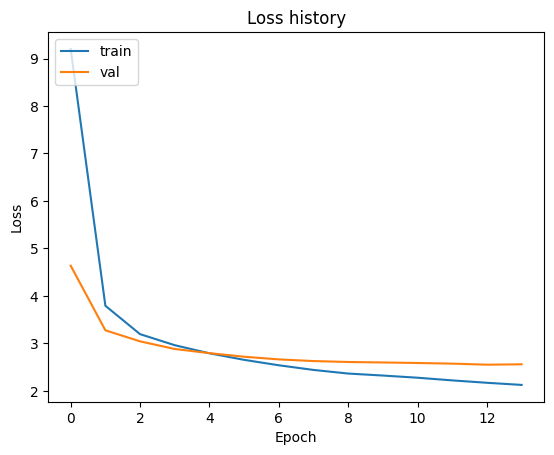

In [18]:
# [Model inferecnce and Plot]

def plot_loss_history(train_loss_history, val_loss_history):
    plt.plot(train_loss_history)
    plt.plot(val_loss_history)
    plt.title('Loss history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
        
if train_loss_history is not None and val_loss_history is not None:
    plot_loss_history(train_loss_history, val_loss_history)


In [19]:
sentences_num = 10

# [Generate sentences]
for i in range(sentences_num):
    print(f"\nExample №{i + 1}")
    print(f"Generated sentence: {predict()[0]}")


Example №1
Generated sentence: Very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very very highly detailed epic photo of face with venetian mask, intricate

Example №2
Generated sentence: portrait of a beautiful woman wearing red venetian mask, intricate, elegant, highly detailed, digital painting, artstation, concept art, by artgerm and greg rutkowski and alphonse mucha

Example №3
Generated sentence: a beautiful digital illustration painting of a detailed gothic fantasy castle and roots, dark mushroom, flowers by benoit b. mandelbrot, steven belledin, martin johnson heade, lee madgwick, caspar david friedrich, and david rios ferreira. 8 k resolution trending on artstation

Example №4
Generated sentence: a beautiful digital illustration painting of a detailed gothic fantasy castle and roots, dark mushroom, flowers by benoit b. mandelbrot, steven belledin, 